In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import datetime as dt
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat

c:\users\keavan\appdata\local\programs\python\python37\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
fileDir = r'C:\Users\Keavan\Jupyter\Economics\Indicator'

In [4]:
def set_start_date():
    indicators = pd.read_csv(fileDir + r'\ref\indicators.csv', header = 0)
    indicators['observation_start'] = pd.to_datetime(indicators['observation_start'])
    global start
    start = max(indicators['observation_start']).strftime('%Y-%m-%d')
    
set_start_date()

end = dt.datetime.today().strftime('%Y-%m-%d')
start

'2006-12-01'

In [5]:
def data_export(start, end): 
    
    indicators = pd.read_csv(fileDir + r'\ref\indicators.csv', header = 0) #indicators.csv or indicators_shortlist.csv
    index = pd.date_range(start, end, freq='D') 
    df = pd.DataFrame(index = index)
    
    index_count = 0
    
    for i in indicators['fred_id']:
        completion = (index_count / len(indicators['fred_id'])) * 100
        df.insert(loc = 0, column = indicators['code'].iloc[index_count], value = web.DataReader(i, 'fred', start, end))
        print('%.1f%% complete: %s successfully added to dataframe.' % (completion, i))
        index_count += 1
    
    df.index.name = 'Date'
    df.to_csv(fileDir + r'\data\indicator_data.csv', header = True)
    print('Data export successful.')

In [6]:
data_export(start, end)

0.0% complete: PCUARETTRARETTR successfully added to dataframe.
1.2% complete: PCUATRADEATRADE successfully added to dataframe.
2.4% complete: WALCL successfully added to dataframe.
3.7% complete: TREAST successfully added to dataframe.
4.9% complete: WSHOMCB successfully added to dataframe.
6.1% complete: EFFR successfully added to dataframe.
7.3% complete: LNU04032231 successfully added to dataframe.
8.5% complete: SPCS20RSA successfully added to dataframe.
9.8% complete: SUUR0000SA0 successfully added to dataframe.
11.0% complete: SUUR0000SA0L1E successfully added to dataframe.
12.2% complete: CPN3M successfully added to dataframe.
13.4% complete: U4RATE successfully added to dataframe.
14.6% complete: MNFCTRMPCSMNSA successfully added to dataframe.
15.9% complete: DGORDER successfully added to dataframe.
17.1% complete: NEWORDER successfully added to dataframe.
18.3% complete: MRTSMPCSM44000USS successfully added to dataframe.
19.5% complete: ISRATIO successfully added to dataframe

In [7]:
def data_wrangling(start, end): 
    df = pd.read_csv(fileDir + r'\data\indicator_data.csv', header = 0).set_index('Date')
    indicators = pd.read_csv(fileDir + r'\ref\indicators.csv', header = 0)
    
    index = pd.date_range(start, end, freq = 'MS')
    
    for i in df.columns:

        freq = indicators['frequency_short'][int(indicators[indicators['code'] == i].index.values)]

        if freq == 'D':
            df[i] = df[i].ffill()
        elif freq == 'W':
            df[i] = df[i].fillna(df[i].rolling(8,  center = True, min_periods=1).mean())
        elif freq == 'M':
            pass
        elif freq == 'Q': #STILL HAVE TO ADAPT TO HANDLE ANNUAL AND QUARTERLY DATA
            pass
        elif freq == 'A':
            pass
    
    df.index = pd.to_datetime(df.index)
    df = df[df.index.day == 1] #only takes first of each month
    df = df.dropna()
    df.to_csv(fileDir + r'\data\filled_nan.csv', header =True)

In [8]:
data_wrangling(start, end)

In [9]:
def model(output): #POOR FORECASTING ABILITY - NEED TO IMPROVE MODEL 
    data = pd.read_csv(fileDir + r'\data\filled_nan.csv', header = 0)
    
    size = int(data.shape[0] * 0.5) #size of training set makes model vary widely
    train, test = data[0:size], data[size:len(data)]
    
    dependent_var = 'PCE'
    
    indicators = pd.read_csv(fileDir + r'\ref\indicators.csv', header = 0)
    indicator_list_format = indicators['code'].tolist()
    unwanted = {'CPI_AllItemExFoodEnergy', 'CPI_AllItemAllCityAvg', 'CPI_UrbanExFoodEnergy', 
                'CPI_IndexForAllUrbanConsumersAllItemsInUSCityAverage', 'PCE_ExFoodEnergy', dependent_var}
    indicator_list = [e for e in indicator_list_format if e not in unwanted]
    indicator_regression_list = "+".join([str(i) for i in indicator_list])
    
    model.lm = smf.ols(formula='{} ~ {}'.format(dependent_var, indicator_regression_list), data=train).fit()
    ynewpred = model.lm.predict(test)
    
    test_data = test[dependent_var].to_numpy()
    result = pd.DataFrame({'PCE': test_data, 'YPred': ynewpred}).astype(float)
    result['Error^2'] = (result['PCE'] - result['YPred']) ** 2
    model.MSE = result['Error^2'].mean()
    del result['Error^2']
    
    if output == 'graph':
        return result.plot(figsize=(15,8))
    elif output == 'summary':
        return model.lm.summary()
    elif output == 'MSE':
        return model.MSE

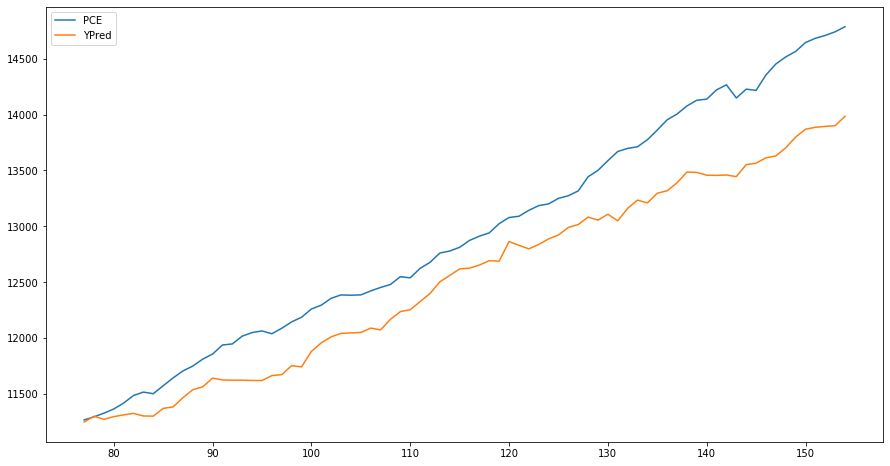

In [10]:
model('graph') #graph, summary or MSE

In [11]:
def results_summary(results, fileNameToSave):
    results_df = pd.DataFrame({"pvals":results.pvalues, "coeff":results.params, 
                               "conf_lower":results.conf_int()[0], "conf_higher":results.conf_int()[1]})
    
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    results_df = results_df[results_df['pvals'] <= 0.05]
    
    results_df.index.name = 'indicators'
        
    return results_df

In [12]:
results_summary(model.lm, 'regression_best_indicators')

,coeff,pvals,conf_lower,conf_higher
indicators,,,,
EMP_UnemploymentDiscouraged,-176.847147,0.045434,-349.783897,-3.910398
INV_ManufacturerSales,-1.675387,0.037837,-3.248199,-0.102575
INV_RetailSales,19.092935,0.000404,9.536568,28.649302
EMP_ChicagoActivity,-67.145164,0.012589,-118.464600,-15.825729
EMP_ContinuedClaims,0.000166,0.044392,0.000005,0.000327
INDU_NondurableGoodsManu,-27.099260,0.017003,-48.886269,-5.312251
EMP_TotalPrivate,-0.728727,0.003688,-1.195197,-0.262257
EMP_AllEmployeesGovt,-0.930155,0.001557,-1.466516,-0.393793
EMP_ConstructionAll,0.743660,0.027792,0.088719,1.398601
